current_pmv will be predicted given the predicted temperature and humidity (lag 30 min)

if current_pmv does not lie in a threshhold ranging from -0.3-+0.3

water temperature will increase by 0.5 or decreased by 0.5 at the first lag.

The prediction will run iteratively and at each prediction the water_temp column will be edited if necessary.

To simulate df as real time data there will be a counter that will increment with each iteration and serve as a reference to split df between future values (not seen by the model) and present and historical values. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from math import sqrt
import logging

from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction.feature_calculators import sum_values, quantile

from pmv import pmv_ppd_diy
from feature_selection import check_stationarity, scaling, feat_extraction

2024-04-06 13:12:08.253856: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-06 13:12:08.255016: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 13:12:08.272557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 13:12:08.272573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 13:12:08.273081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
df_trained = pd.read_csv("/home/fraia/Arduino/Predictive Model/data_cl/home_data_cl_21_03.csv")
df = pd.read_csv("/home/fraia/Arduino/Predictive Model/data/Unseen.csv")

In [3]:
df_trained_cl = df_trained[::6]
df_trained_cl = df_trained_cl.drop(columns = ["Unnamed: 0", "id"])
df_trained_cl = df_trained_cl.set_index("timestamp")
df_trained_cl.isna().sum()

sense_hum     0
sense_temp    0
open_hum      0
open_temp     0
pressure      0
water_temp    0
dtype: int64

In [4]:
df_cl = df[::6]
df_cl.reset_index(drop=True, inplace=True)

In [5]:
columns_drop = ["id"]
df_cl = df_cl.drop(columns=columns_drop)

df_cl["timestamp"] = pd.to_datetime(df_cl["timestamp"])
df_cl = df_cl.set_index("timestamp")
df_cl = df_cl[1:]

In [6]:
display(df_trained_cl)
display(df_cl)

,sense_hum,sense_temp,open_hum,open_temp,pressure,water_temp
timestamp,,,,,,
2024-02-21 09:24:31,40.8,21.9,70.0,6.74,1027.0,30.0
2024-02-21 09:50:24,41.6,21.6,68.0,7.30,1028.0,28.0
2024-02-21 10:21:54,41.5,21.7,65.0,8.89,1028.0,27.0
2024-02-21 10:52:40,41.4,21.7,64.0,9.80,1028.0,26.0
2024-02-21 11:18:14,41.4,21.8,62.0,10.47,1027.0,25.0
...,...,...,...,...,...,...
2024-03-05 05:15:55,38.5,21.9,70.0,5.98,1021.0,30.0
2024-03-05 05:46:33,38.2,22.0,70.0,6.01,1021.0,30.0
2024-03-05 06:17:12,38.1,22.0,70.0,6.10,1021.0,30.0


,sense_hum,sense_temp,open_hum,open_temp,pressure,water_temp
timestamp,,,,,,
2024-03-05 07:44:01,38.0,22.1,67,5.51,1022,NaN
2024-03-05 08:35:08,37.7,22.2,67,5.73,1022,NaN
2024-03-05 09:05:47,37.6,22.1,67,6.35,1023,NaN
2024-03-05 09:36:27,37.4,22.2,67,6.92,1010,NaN
2024-03-05 10:07:07,37.3,22.1,62,8.07,1023,NaN
...,...,...,...,...,...,...
2024-03-07 16:50:28,37.4,21.8,82,9.00,1006,NaN
2024-03-07 17:21:12,37.6,21.7,86,8.81,1005,NaN
2024-03-07 17:57:26,37.8,21.6,84,8.85,1004,NaN


In [7]:
df_cl

,sense_hum,sense_temp,open_hum,open_temp,pressure,water_temp
timestamp,,,,,,
2024-03-05 07:44:01,38.0,22.1,67,5.51,1022,NaN
2024-03-05 08:35:08,37.7,22.2,67,5.73,1022,NaN
2024-03-05 09:05:47,37.6,22.1,67,6.35,1023,NaN
2024-03-05 09:36:27,37.4,22.2,67,6.92,1010,NaN
2024-03-05 10:07:07,37.3,22.1,62,8.07,1023,NaN
...,...,...,...,...,...,...
2024-03-07 16:50:28,37.4,21.8,82,9.00,1006,NaN
2024-03-07 17:21:12,37.6,21.7,86,8.81,1005,NaN
2024-03-07 17:57:26,37.8,21.6,84,8.85,1004,NaN


In [8]:
predictions = []
hvac_final = []
pmv_final = []


#df_rolled = df_rolled.drop(columns = "pressure")

In [9]:
class Thermostat:
     def __init__(self, df_train, df_unseen, heating_rate, cooling_rate, threshold, model_path = "/home/fraia/Arduino/Predictive Model/LSTM/models_temp/model11_21_01.h5"):
         self.counter = 0
         #self.upper_bound = self.updated[-1]-len(hvac_final)
         #self.lower_bound = 6
         self.n_past = 5
         self.n_future = 1
         self.model = load_model(model_path)
         
         self.adjustment = 0
         self.df1 = df_train
         self.df2 = df_unseen
         self.updated = self.concat()
         self.rolled = self.rolling(self.updated)
         self.relevant_vars = ["sense_temp", "st_wt", "open_temp__sum_values", 'sense_hum__quantile__q_0.8']

         self.heating_rate = heating_rate
         self.cooling_rate = cooling_rate
         self.threshold = threshold
     
     def concat(self):
          print("Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          print("counter:", self.counter)
          print("predictions", predictions)
          print("hvac", hvac_final)
          df = self.df1
          unseen_rows = self.df2.head(self.counter)
          df_updated = pd.concat([df, unseen_rows], axis = 0)

          if len(hvac_final) > 0:
               df_updated["water_temp"][-len(hvac_final):] = hvac_final
               #df_updated["water_temp"][df.index[-1]:len(hvac_final)] = hvac_final
          if len(predictions) > 0:
               df_updated["sense_temp"][-len(predictions):] = predictions
          print("updated:", df_updated.tail())
          return df_updated

     def rolling(self, df):
          print("Rolling...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          df_rolled = df.rolling(window=20).mean().dropna()
          df_rolled = df_rolled[['sense_temp','water_temp','sense_hum', 'open_temp', 'open_hum']]
          print("rolled:\n", df_rolled)
          
          if np.isnan(df_rolled["water_temp"].iloc[-1]):
               if len(hvac_final) > 0:
                    df_rolled["water_temp"][-1] = hvac_final[-1]
               else:
                    df_rolled["water_temp"][-1] = df_rolled["water_temp"][-2]
                    
          if len(predictions) > 0:
               df_rolled["sense_temp"][-1] = predictions[-1]

          df_rolled["st_wt"] = df_rolled["sense_temp"]*df_rolled["water_temp"]
          print("df_rolled:\n",df_rolled.tail())
          return df_rolled
     
     def preprocessing(self, df):
          print("Preprocessing...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          df_diff = df.diff().dropna()
          print("df_diff:",df_diff)
          df_stationar = check_stationarity(df_diff)
          print("df_stationar:\n",df_stationar)
          df_scaled, scaler = scaling(df_stationar)
          print("scaled:\n",df_scaled)
          #X, y = feat_extraction(df_scaled, "sense_temp")
          #df_scaled = df_scaled.set_index("timestamp")
          df_fe = df_scaled
          df_fe["open_temp__sum_values"] = sum_values(x = df_fe["open_temp"])
          df_fe["sense_hum__quantile__q_0.8"] = quantile(x = df_fe["sense_hum"], q = 0.8)
          df_ready = pd.concat([df_scaled["sense_temp"], df_scaled["st_wt"], df_fe["open_temp__sum_values"], df_fe["sense_hum__quantile__q_0.8"]], axis = 1)
          print("ready:\n",df_ready)
          return df_ready, scaler
          
     def pred_df(self, df):
          print("Slicing required time window...---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          pred_df = pd.DataFrame(df[-6:], columns=df.columns)
          print("pred_df:\n",pred_df)
          return pred_df

     def x_array(self, df):
          print("Shaping 3D array...------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          X = []

          for i in range(self.n_past, len(df) - self.n_future + 1):
              X.append(df.iloc[i - self.n_past:i, :])
          X = np.array(X)

          print("shape: {}\n".format(X.shape)) 
          return X
     
     def predictions(self, array):
          print("Predicting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
          prediction = self.model.predict(array)
          return prediction
     
     def wrapping_or_adjusting(self, pred, scaler):
          global predictions, hvac_final
          # Unscaling 
          # Transformation to real values (without scaling and difference)
          forecast_copies = np.repeat(pred, self.rolled.shape[1], axis = -1)
          y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]

          # Differencing
          #last real value of train set
          if len(predictions) == 0:
              diff_value = self.rolled["sense_temp"][-1]
          else:
              diff_value = predictions[-1]
          
          y_pred_real = y_pred_future.cumsum() + diff_value
          hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future

          print("The predicted temperature for {0} is {1}°C".format(self.rolled.index[-1], y_pred_real[0]))
              
          if self.adjustment == 1:
               print("Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
               # Compute predicted pmv for adjustment made 
               pmv_ppd = pmv_ppd_diy(predicted_temp=y_pred_real, predicted_hum=hum_pred)

               # Update lists
               predictions.append(y_pred_real[0])
               pmv_final.append(pmv_ppd["pmv"][0])
               
               # Update trackers
               self.adjustment -= 1
               self.counter += 1
               #self.upper_bound += 1
               #self.lower_bound += 1

          else:
               self.adjustment += 1
               def heat():
                    print("Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
                    pmv_ppd = pmv_ppd_diy(predicted_temp=y_pred_real, predicted_hum=hum_pred)
                    pmv_difference = pmv_ppd["pmv"][0] - 0
                    pmv_difference = pmv_difference**2
                    pmv_difference = sqrt(pmv_difference)

                    current_wt = self.rolled["water_temp"].iloc[-1]
                    
                    if current_wt <= self.threshold:
                         if pmv_ppd["pmv"][0] < -2:
                              print("Critical thermal comfort violation...")
                              current_wt += self.heating_rate * pmv_difference
                         elif pmv_ppd["pmv"][0] > 2:
                              print("Critical thermal comfort violation...")
                              current_wt -= self.cooling_rate * pmv_difference
                         elif (-2 < pmv_ppd["pmv"][0] < -1):
                              print("High thermal comfort violation...")
                              current_wt += self.heating_rate * pmv_difference
                         elif (1 < pmv_ppd["pmv"][0]< 2):
                              print("High thermal comfort violation...")
                              current_wt -= self.cooling_rate * pmv_difference
                         elif (-1 <= pmv_ppd["pmv"][0] < -0.1):
                              print("Low thermal comfort violation...")
                              current_wt += self.heating_rate * pmv_difference
                         elif (0.1 < pmv_ppd["pmv"][0] <= 1):
                              print("Low thermal comfort violation...")
                              current_wt -= self.cooling_rate * pmv_difference
                         else:
                             print("Within thermal comfort") 
                    hvac_final.append(current_wt)
               heat()
               
          print("==================================================================================================================================================================================================================================================")      
          return y_pred_real  

     def run_simulation(self):
          while self.counter < len(self.df2):
              updated_df = self.concat()
              rolled_df = self.rolling(df = updated_df)
              df_ready, scaler = self.preprocessing(rolled_df)
              df_pred = self.pred_df(df_ready)
              X = self.x_array(df_pred)
              prediction = self.predictions(X)
              self.wrapping_or_adjusting(prediction, scaler)

          
 

In [10]:
thermostat = Thermostat(df_train=df_trained_cl, df_unseen=df_cl, heating_rate=10, cooling_rate=10, threshold=40)

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 0
predictions []
hvac []
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 05:15:55       38.5        21.9      70.0       5.98    1021.0   
2024-03-05 05:46:33       38.2        22.0      70.0       6.01    1021.0   
2024-03-05 06:17:12       38.1        22.0      70.0       6.10    1021.0   
2024-03-05 06:47:51       38.0        22.1      71.0       5.49    1021.0   
2024-03-05 07:18:29       38.0        22.1      67.0       5.56    1022.0   

                     water_temp  
timestamp                        
2024-03-05 05:15:55        30.0  
2024-03-05 05:46:33        30.0  
2024-03-05 06:17:12   

2024-04-06 13:12:10.928311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-06 13:12:10.928521: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
logging.basicConfig(level=logging.INFO)  # Set logging level
thermostat.run_simulation()

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 0
predictions []
hvac []
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 05:15:55       38.5        21.9      70.0       5.98    1021.0   
2024-03-05 05:46:33       38.2        22.0      70.0       6.01    1021.0   
2024-03-05 06:17:12       38.1        22.0      70.0       6.10    1021.0   
2024-03-05 06:47:51       38.0        22.1      71.0       5.49    1021.0   
2024-03-05 07:18:29       38.0        22.1      67.0       5.56    1022.0   

                     water_temp  
timestamp                        
2024-03-05 05:15:55        30.0  
2024-03-05 05:46:33        30.0  
2024-03-05 06:17:12   

/tmp/ipykernel_14324/3732815235.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff_value = self.rolled["sense_temp"][-1]
/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work t

open_temp
ADF Statistic: -3.656625
p-value: 0.004766


open_hum
ADF Statistic: -3.852247
p-value: 0.002416


st_wt
ADF Statistic: -5.347518
p-value: 0.000004


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41    -0.01500    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20    -0.00500     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52    -0.01000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24    -0.01500     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02    -0.02000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 05:46:33     0.03500     0.40000     -0.160    -0.2205     -0.45   
2024-03-05 06:17:12     0.03500     0.45000     -0.165    -0.1925     -0.55   
2024-03-05 06:47:51     0.04500    

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

df_diff:                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 06:17:12    0.035000     0.45000     -0.165    -0.1925     -0.55   
2024-03-05 06:47:51    0.045000     0.45000     -0.170    -0.2170     -0.40   
2024-03-05 07:18:29    0.050000     0.54125     -0.175    -0.2230     -0.25   
2024-03-05 07:44:01    0.022668     0.53625     -0.180    -0.2120     -0.05   
2024-03-05 08:35:08    0.081092     0.48125

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

scaled:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.345418   -1.489525   1.146276   1.670172 -0.319319   
2024-02-21 19:32:20   -0.108264   -0.039240   0.809369   1.442135 -0.077051   
2024-02-21 19:57:52   -0.226841    0.142045   0.905628   1.013983  0.165218   
2024-02-21 20:23:24   -0.345418    0.504616   0.953757   0.730101  0.286352   
2024-02-21 20:54:02   -0.463995    0.685902   1.001887   0.497410  0.468054   
...                         ...         ...        ...        ...       ...   
2024-03-05 06:47:51    1.077505    1.592330  -1.597109  -0.966216 -0.501021   
2024-03-05 07:18:29    1.196082    1.923176  -1.645239  -0.994138 -0.319319   
2024-03-05 07:44:01    0.547892    1.905047  -1.693369  -0.942946 -0.077051   
2024-03-05 08:35:08    0.732162    1.705633  -1.885887  -0.880120  0.225785   
2024-03-05 09:05:47    2.312223    0.708563

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_hum
ADF Statistic: -3.820645
p-value: 0.002703


st_wt
ADF Statistic: -5.370634
p-value: 0.000004


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 07:18:29    0.050000     0.54125     -0.175    -0.2230     -0.25   
2024-03-05 07:44:01    0.022668     0.53625     -0.180    -0.2120     -0.05   
2024-03-05 08:35:08    0.030438     0.48125     -0.200    -0.1985      0.20   
2024-03-05 

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 14ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.6817626953125°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 6
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425]
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                                   
2024-03-05 08:35:08       37.7   21.508760      6

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

sense_temp
ADF Statistic: -4.458133
p-value: 0.000234


water_temp
ADF Statistic: -5.233421
p-value: 0.000008


sense_hum
ADF Statistic: -4.249955
p-value: 0.000542


open_temp
ADF Statistic: -3.710831
p-value: 0.003963


open_hum
ADF Statistic: -3.674208
p-value: 0.004491


st_wt
ADF Statistic: -5.225277
p-value: 0.000008


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 09:05:47    0.0

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 12ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.797422409057617°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 8
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325]
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                      

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 25ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.828554153442383°C
Adjusting...--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Low thermal comfort violation...
Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 9
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998]
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp        

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

open_hum
ADF Statistic: -3.693662
p-value: 0.004203


st_wt
ADF Statistic: -5.135497
p-value: 0.000012


df_stationar:
                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 10:37:48    0.039088     0.02125     -0.190     0.0410     -0.25   
2024-03-05 11:13:34    0.036197     0.02125     -0.185     0.0815     -0.50   
2024-03-05 11:44:12    0.033150     0.01625     -0.185     0.1125     -0.50   
2024-03-05 

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

The predicted temperature for 2024-03-05 07:18:29 is 21.856809616088867°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 11
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 31.224999999999998]
updated:                      sense_hum  sense_temp  open_hum  open_temp  pressure  \
timestamp                                                 

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

df_diff:                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 11:44:12    0.033150     0.01625     -0.185     0.1125     -0.50   
2024-03-05 12:14:52    0.029865     0.01125     -0.170     0.1555     -0.60   
2024-03-05 12:45:31    0.021422     0.01125     -0.150     0.2035     -0.80   
2024-03-05 13:16:11    0.022840     0.01125     -0.120     0.2260     -0.90   
2024-03-05 13:46:57    0.125036     0.05625

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 18ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.920639038085938°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 14
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 31.224999999999998, 31.224999999999998, 31.125, 31.125]
updated:                

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

df_diff:                      sense_temp  water_temp  sense_hum  open_temp  open_hum  \
timestamp                                                                     
2024-02-21 19:01:41   -0.015000    -0.40000      0.115     0.3495     -0.25   
2024-02-21 19:32:20   -0.005000     0.00000      0.080     0.3005     -0.05   
2024-02-21 19:57:52   -0.010000     0.05000      0.090     0.2085      0.15   
2024-02-21 20:23:24   -0.015000     0.15000      0.095     0.1475      0.25   
2024-02-21 20:54:02   -0.020000     0.20000      0.100     0.0975      0.40   
...                         ...         ...        ...        ...       ...   
2024-03-05 13:16:11    0.022840     0.01125     -0.120     0.2260     -0.90   
2024-03-05 13:46:57    0.019022     0.06125     -0.115     0.2675     -1.20   
2024-03-05 14:17:42    0.015080     0.05625     -0.100     0.2865     -1.20   
2024-03-05 14:48:21    0.011032     0.05625     -0.080     0.3155     -1.25   
2024-03-05 15:19:01    0.136995     0.05625

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 24ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.95182228088379°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 16
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 31.224999999999998, 31.224999999999998, 31.125, 31.125, 31.

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 11ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.9632511138916°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 17
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 31.224999999999998, 31.224999999999998, 31.125, 3

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

1/1 [==============================] - 0s 12ms/step
The predicted temperature for 2024-03-05 07:18:29 is 21.971338272094727°C
Adjustment already made, wrapping it up...----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Concatenating...-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

counter: 18
predictions [21.45336, 21.50876, 21.55517, 21.599121, 21.640217, 21.681763, 21.723936, 21.762995, 21.79731, 21.828438, 21.85681, 21.88043, 21.901608, 21.920639, 21.937523, 21.951822, 21.963251, 21.971338]
hvac [31.825, 31.724999999999998, 31.625, 31.625, 31.525, 31.425, 31.425, 31.325, 31.325, 31.224999999999998, 31.224999999999998, 31.2249999999999

/tmp/ipykernel_14324/3732815235.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hum_pred = self.rolled["sense_hum"][-1] #watch out, taking current humidity value and not future
/tmp/ipykernel_14324/3732815235.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assign

KeyError: 'sense_temp'

In [ ]:
#df_final[:15].to_csv("/home/fraia/Arduino/Predictive Model/LSTM/trial_data/df_final_15.csv")

In [ ]:
forecast_period = pd.date_range(list(df_trained_cl.index)[-1], periods=len(hvac_final)+1, freq="30min").tolist()
forecast_period = forecast_period[1:]

In [ ]:
hvac_series = pd.DataFrame(hvac_final, index = forecast_period, columns=["water_temp"])
predictions_series = pd.DataFrame(predictions, index = forecast_period[:len(predictions)], columns=["sense_temp"])
pmv_series = pd.DataFrame(pmv_final, index=forecast_period[:len(pmv_final)], columns=["pmv"])
open_temp = pd.Series(df_cl["open_temp"])
df_results = pd.concat([hvac_series, predictions_series, pmv_series], axis=1)
df_results["open_temp"] = open_temp.values

#Historical values
cols = ["sense_temp", "water_temp", "open_temp"]
df_historical = df_trained_cl[cols]

In [ ]:
df_results.index = pd.to_datetime(df_results.index) 
df_results.index.name = "timestamp"
df_trained_cl.index = pd.to_datetime(df_trained_cl.index)

In [ ]:
display(df_results)
display(df_historical)

,water_temp,sense_temp,pmv,open_temp
timestamp,,,,
2024-03-05 07:48:29,31.825,21.453360,-0.25,5.51
2024-03-05 08:18:29,31.725,21.508760,-0.24,5.73
2024-03-05 08:48:29,31.625,21.555170,-0.23,6.35
2024-03-05 09:18:29,31.625,21.599121,-0.23,6.92
2024-03-05 09:48:29,31.525,21.640217,-0.22,8.07
...,...,...,...,...
2024-03-07 10:18:29,30.825,22.157936,-0.15,9.00
2024-03-07 10:48:29,30.825,22.155413,-0.15,8.81
2024-03-07 11:18:29,30.825,22.152916,-0.15,8.85


,sense_temp,water_temp,open_temp
timestamp,,,
2024-02-21 09:24:31,21.9,30.0,6.74
2024-02-21 09:50:24,21.6,28.0,7.30
2024-02-21 10:21:54,21.7,27.0,8.89
2024-02-21 10:52:40,21.7,26.0,9.80
2024-02-21 11:18:14,21.8,25.0,10.47
...,...,...,...
2024-03-05 05:15:55,21.9,30.0,5.98
2024-03-05 05:46:33,22.0,30.0,6.01
2024-03-05 06:17:12,22.0,30.0,6.10


In [ ]:
df_comparison = pd.concat([df_historical,df_results[["sense_temp", "water_temp", "open_temp"]]], axis=0)
df_comparison

,sense_temp,water_temp,open_temp
timestamp,,,
2024-02-21 09:24:31,21.900000,30.000,6.74
2024-02-21 09:50:24,21.600000,28.000,7.30
2024-02-21 10:21:54,21.700000,27.000,8.89
2024-02-21 10:52:40,21.700000,26.000,9.80
2024-02-21 11:18:14,21.800000,25.000,10.47
...,...,...,...
2024-03-07 10:18:29,22.157936,30.825,9.00
2024-03-07 10:48:29,22.155413,30.825,8.81
2024-03-07 11:18:29,22.152916,30.825,8.85


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_results)
df_scaled = pd.DataFrame(df_scaled, columns=df_results.columns, index=df_results.index)

In [ ]:
scaler2 = StandardScaler()
df_scaled2 = scaler2.fit_transform(df_comparison)
df_scaled2 = pd.DataFrame(df_scaled2, columns=df_comparison.columns, index=df_comparison.index)

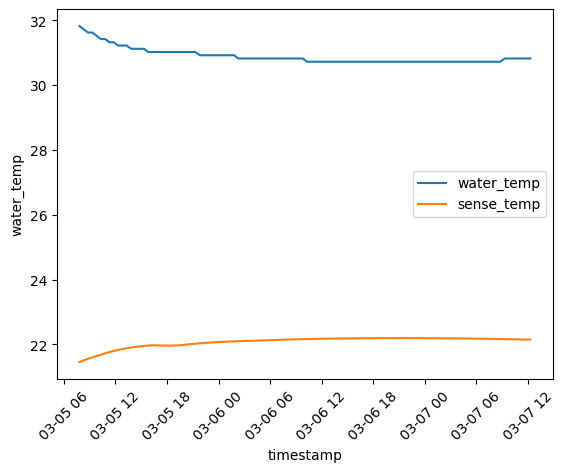

In [ ]:
import seaborn as sns

sns.lineplot(data = df_results, x = df_scaled.index, y = "water_temp", label = "water_temp")
sns.lineplot(data = df_results, x = df_scaled.index, y = "sense_temp",label = "sense_temp")

plt.xticks(rotation = 45)
plt.legend()
plt.show()

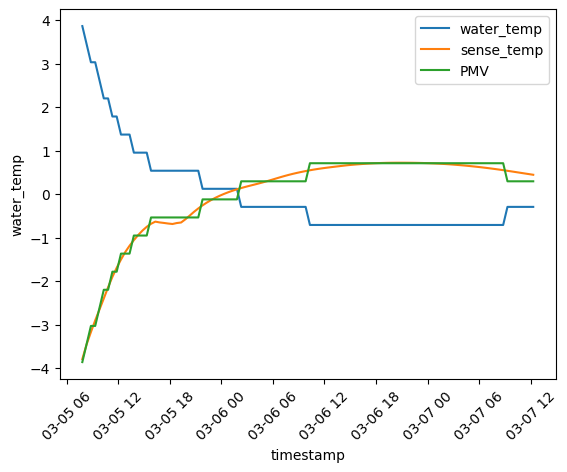

In [ ]:
import seaborn as sns

sns.lineplot(data = df_scaled, x = df_scaled.index, y = "water_temp", label = "water_temp")
sns.lineplot(data = df_scaled, x = df_scaled.index, y = "sense_temp",label = "sense_temp")

plt.xticks(rotation = 45)
plt.legend()
plt.show()

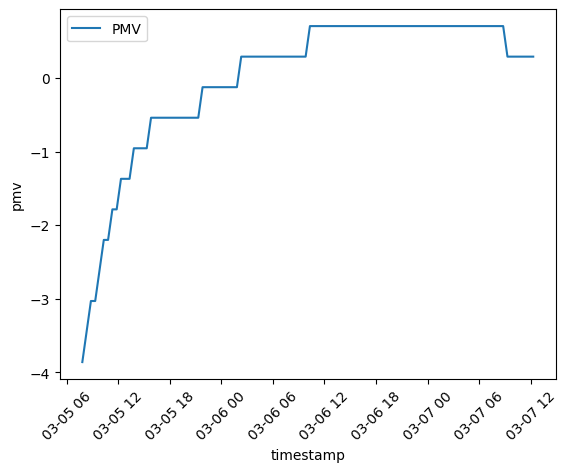

In [ ]:
sns.lineplot(data = df_scaled, x = df_scaled.index, y = "pmv", label = "PMV")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

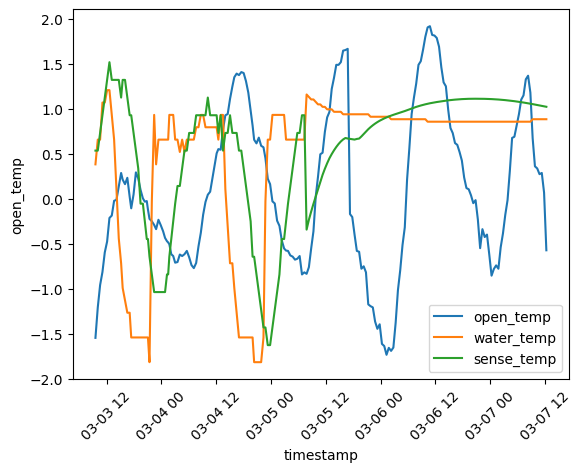

In [ ]:
sns.lineplot(data = df_scaled2[-200:], x = df_scaled2.index[-200:], y = "open_temp", label = "open_temp")
sns.lineplot(data = df_scaled2[-200:], x = df_scaled2.index[-200:], y = "water_temp", label = "water_temp")
sns.lineplot(data = df_scaled2[-200:], x = df_scaled2.index[-200:], y = "sense_temp",label = "sense_temp")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

### Sketching

In [ ]:
  #def replace_temperatures(self, df):
     #     print("Updating values...-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
     #     print("counter:", self.counter)
     #     print("upper_bound", self.upper_bound)
     #     print("lower_bound",self.lower_bound)
     #     global predictions, hvac_final
     #     print("predictions", predictions)
     #     print("hvac", hvac_final)
     #     # If statements to insert values saved in lists
     #     if len(predictions) > 0:
     #          df["sense_temp"][6:6 + len(predictions)] = predictions
     #          
     #     if len(hvac_final) > 0:
     #          df["water_temp"][5:5 + len(hvac_final)] = hvac_final
#
     #     # Create interaction term
     #     df["st_wt"] = df["sense_temp"] * df["water_temp"]
     #     print("updated:\n",df.head(30))
     #     return df